In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class MSM(object):
    def __init__(self, n=1e4, timesteps=100):
        '''
        Initialize a new microsimulation
        
        TODO: move n, attributes, and updates into a new Entity() class
            that way you can have separate sets of entities in a single MSM
            each with their own attributes and update mechanisms
        e.g. 1e5 patients and 100 physicians
            then the patients can have a physician_id key to lookup their doctor
            and patient updates can depend on physician attributes
            (e.g. whether or not a doctor has a stock of antihypertensives available)
        -----------------------------------------------------------------------------
        n : int, default 1e4
            number of simulants
        timesteps : int, default 100
            number of timesteps to simulate
        '''
        # store size of simulation
        self.n = int(n)
        self.timesteps = int(timesteps)
        # store current timestep
        self.timestep = 0
        # build a panel in which to store the attributes
        self.attributes = pd.Panel(
            major_axis=pd.Index(np.arange(self.n), name='id'), 
            minor_axis=pd.Index(np.arange(self.timesteps), name='timestep')
        )
        # make an ordered list of update functions
        self.updates = []

    def add_attribute(self, name, init, time_varying=True):
        '''
        Add a new attribute to the microsimulation
        
        TODO: should probably just implement an Attribute() class for this
        TODO: use forecasting's simbuilder tool to generate attributes/updaters from YAML
        ---------------------------------------------------------------------------------
        name : str
            name of the attribute (must be unique)
        init : array or function
            either a numpy array of length MSM.n containing values for first timestep
            or a function which (given MSM) returns such an array
        time_varying : boolean, default True
            whether or not the attribute varies over time
        '''
        # check that attribute name is unique
        if name in self.attributes.items:
            raise NameError('An attribute named {} already exists.'.format(name))
        # build an empty array for the attribute
        self.attributes[name] = np.nan
        # initialize for first timestep
        if hasattr(init, '__call__'): # check if it's a function...
            self.attributes[name].ix[:,0] = init(self)
        else: # otherwise it should be an array
            self.attributes[name].ix[:,0] = init
        # copy to all timesteps if not a time-varying attribute
        # note: more memory efficient methods could be considered...
        if not time_varying:
            self.attributes[name] = self.attributes[name].ffill(axis=1)

    def add_update(self, name, attr, update_fun):
        '''
        Add an updater to the model, which will be called upon each timestep
        
        Note: updaters will be called in the order they're added
        Note: there should probably be an 'Update' Class instead of this weird dict
        
        TODO: this could be an Update() class
            or potentially part of Attribute() class, but need to think of how to keep track of order
        TODO: add option to parse a symbolic expression using sympy instead of requiring update_fun
            short term will make coding easier; long term could be specified in config files instead
        ---------------------------------------------------------------------------------------------
        name : str
            name of the updater (must be unique)
        attr : str
            attribute to update
        update_fun : function
            function which takes in MSM and returns an MSM.n-sized array of updated results
        '''
        if name in [u['name'] for u in self.updates]:
            raise NameError('An update named {} already exists.'.format(name))
        self.updates += [{
            'name': name,
            'attr': attr,
            'update_fun': update_fun
        }]
        
    def __call_update(self, u):
        self.attributes[u['attr']].ix[:,self.timestep] = u['update_fun'](self)
    
    def __advance_simulation(self):
        self.timestep += 1
        for u in self.updates:
            self.__call_update(u)
            
    def get_attribute(self, attribute, timestep_abs=None, timestep_delta=None, id=None):
        '''
        Convenience function to return an attribute for a particular time/simulant
        -----------------------------------------------------------------------------------------
        attribute : str
            name of the attribute to lookup
        timestep_abs : int, default None
            if specified, a particular (absolute) timestep to lookup
            if neither timestep_abs or timestep_delta specified, defaults to current MSM.timestep
        timestep_delta : (signed) int, default None
            if specified, looks up a particular timestep relative to the current one
            e.g timestep_delta = -1 would mean to lookup MSM.timestep - 1
        id : int, default None
            particular simulant to lookup
            if None, returns vector of all simulants (default)
        '''
        if timestep_abs is not None and timestep_delta is not None:
            raise RuntimeError('''Both timestep_abs and timestep_delta specified.
                Only one can be used at a time.''')
        timestep = self.timestep if timestep_abs is None else timestep
        if timestep_delta is not None:
            timestep += timestep_delta
        return self.attributes[attribute].ix[:,timestep]
            
    def run_simulation(self):
        while self.timestep < self.timesteps - 1:
            self.__advance_simulation()

In [3]:
### start a new model
m = MSM()

### add attributes
# age, initialized to 0
m.add_attribute('age', np.zeros(m.n))
# sex (stored as female boolean)
def random_sex(msm, p=0.5):
    return np.random.binomial(size=msm.n, p=p, n=1)
m.add_attribute('female', random_sex, time_varying=False)
# alive, initialized to 1
m.add_attribute('alive', np.ones(m.n))

### add updaters
# age, just advance 1
def age_update(msm):
    prev_age = msm.get_attribute('age', timestep_delta=-1)
    return prev_age + 1
m.add_update('increase_age', 'age', age_update)
# alive, give a probability of dying based on age
# if already dead, always dead
def alive_update(msm):
    prev_alive = msm.get_attribute('alive', timestep_delta=-1)
    age = msm.get_attribute('age')
    return np.random.binomial(size=msm.n, p=(prev_alive * (1. - (age / 1000.))), n=1)
m.add_update('kill_people', 'alive', alive_update)

### run the simulation
m.run_simulation()

### inspect the results
m.attributes.to_frame(False).head()

age  female  alive
id timestep                    
0  0           0       1      1
   1           1       1      1
   2           2       1      1
   3           3       1      1
   4           4       1      1

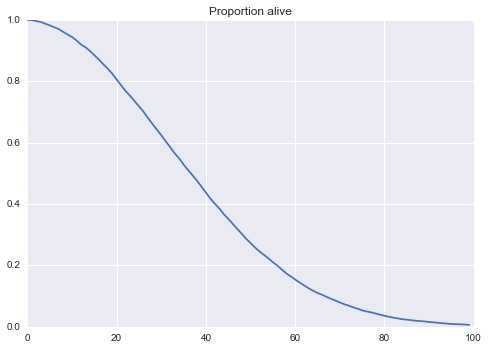

In [4]:
plt.plot(m.attributes['alive'].mean(axis=0))
plt.title('Proportion alive')

In [5]:
%timeit m.run_simulation()

The slowest run took 7.36 times longer than the fastest. This could mean that an intermediate result is being cached 
1000000 loops, best of 3: 259 ns per loop
